## **ROTTEN TOMATOES MOVIE RATING PREDICTION**

I built a classifier to predict Rotten Tomatoes movie status (Rotten, Fresh, Certified Fresh) using two approaches: structured features from rotten_tomatoes_movies.csv and text reviews from rotten_tomatoes_critic_reviews_50k.csv. On the structured side, I cleaned the data, selected numeric features (runtime, critic and audience metrics), and encoded categories correctly: one-hot for nominal labels like content_rating, and 0/1 encoding for binary flags such as audience or tomatometer status. I performed a train–test split, trained a Decision Tree as a baseline, then moved to a Random Forest to improve generalization. To handle class imbalance, I computed class weights with balanced and trained a weighted forest. I evaluated models with accuracy, precision, recall, F1, and confusion matrices, and I 
plotted feature importances to see which variables drove predictions.

For the text approach, I took a subset of critic reviews, encoded the target (Fresh=1, Rotten=0), and vectorized review_content with CountVectorizer (bag-of-words). I trained a Random Forest on these vectors, evaluated it with the same metrics, and visualized a confusion matrix. I also applied the fitted vectorizer and model to new reviews for a specific movie and summarized results by computing the share of positive predictions and mapping that to an overall status.

### Step 1: Import Required Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

## First Approach: Predicting Movie Status Based on Numerical and Categorical Features

Predict movie status using numeric and categorical features from rotten_tomatoes_movies.csv. The dataset includes title, genre, cast, release date, production company, runtime, critic and audience ratings, and the Tomatometer. Load the file and preview its structure to understand columns and data quality.

In [4]:
file_path = "/Users/madhulika/Downloads/rotten_tomatoes_movies.csv"
df_movie = pd.read_csv(file_path)
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


As we can see, there are several columns available in our dataset:

1. rotten_tomatoes_link: permalink to the movie’s Rotten Tomatoes page
2. movie_title: title of the film
3. movie_info: brief synopsis
4. critics_consensus: summary of the prevailing critic opinion
5. content_rating: suitability rating based on content
6. genres: movie genre tags
7. directors: director names
8. authors: screenwriter credits
9. actors: principal cast
10. original_release_date: theatrical release date
11. streaming_release_date: streaming release date
12. runtime: duration in minutes
13. production_company: producing studio
14. tomatometer_status: Rotten Tomatoes classification to be predicted
15. tomatometer_rating: Tomatometer score
16. tomatometer_count: number of critic reviews
17. audience_status: audience classification
18. audience_rating: audience score
19. audience_count: number of audience reviews
20. tomatometer_top_critics_count: count of reviews by top critics
21. tomatometer_fresh_critics_count: count of top critic reviews labeled fresh
22. tomatometer_rotten_critics_count: count of top critic reviews labeled rotten

Let's take a look at the summary of our data to better understand it

In [5]:
df_movie.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


### Data Preprocessing

From the data summary, the numeric features include runtime, tomatometer_rating, tomatometer_count, audience_rating, audience_count, and the critic count fields (top, fresh, rotten). These will serve as predictors for the target variable tomatometer_status. Some of these columns contain missing values that will need to be handled later.

Before moving forward, I want to add features that could improve the predictive strength of the tree models. I’ll begin with the content_rating variable, which is categorical with values like R, PG, and NR.

Content Rating Category: ['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


[Text(0, 0, '6377'),
 Text(0, 0, '5474'),
 Text(0, 0, '2979'),
 Text(0, 0, '2168'),
 Text(0, 0, '676'),
 Text(0, 0, '38')]

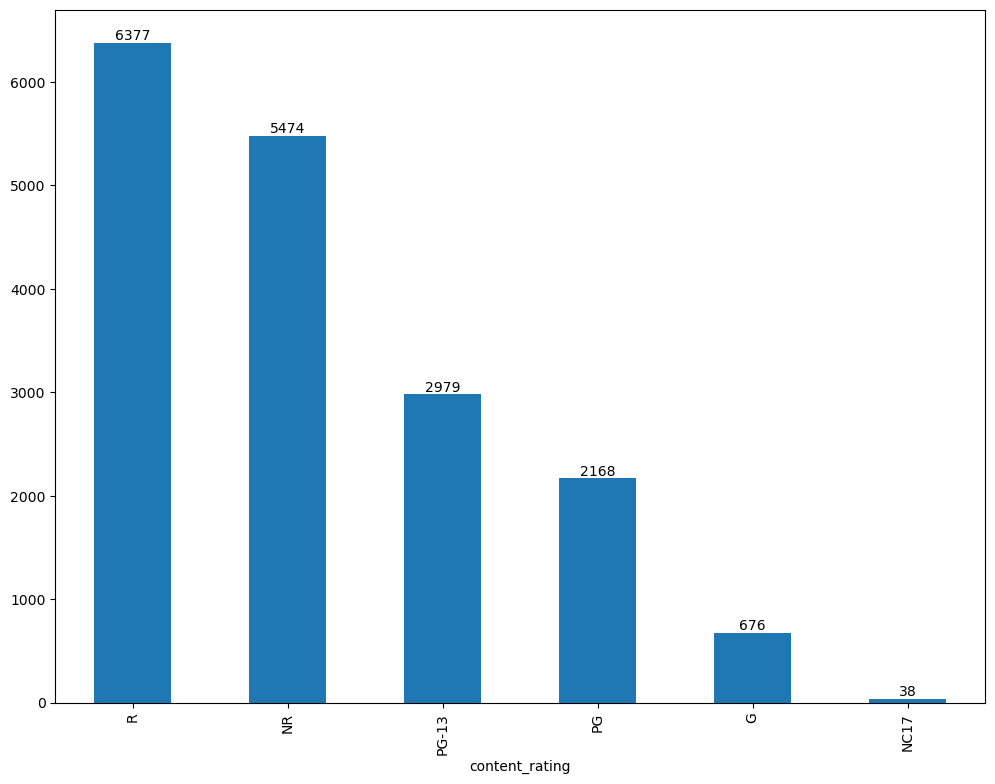

In [9]:
print(f'Content Rating Category: {df_movie.content_rating.unique()}')

#Visualize the distribution of each category
ax = df_movie.content_rating.value_counts().plot(kind='bar',figsize=(12,9))
ax.bar_label(ax.containers[0])

I’m taking the categorical column content_rating and converting it to numbers so the model can learn from it. Models expect numeric inputs, so categories need encoding. There are two common choices, and I am picking based on what the data means:
1. Ordinal encoding when categories have a natural order, for example poor → 0, average → 1, good → 2.
2. One hot encoding when categories have no order, for example colors: black → [1,0,0], red → [0,1,0], blue → [0,0,1].

Since content_rating values like G, PG, PG-13, R, NR do not represent a ranked magnitude, I am applying one hot encoding. In code, this looks like using pd.get_dummies(df_movie.content_rating) and then concatenating the resulting indicator columns into the feature set.

In [101]:
content_rating = pd.get_dummies(df_movie.content_rating)
content_rating.head()

,G,NC17,NR,PG,PG-13,R
0,False,False,False,True,False,False
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,True,False,False,False
4,True,False,False,False,False,False


Preprocessing audience_status as a binary predictor. It has two categories, Spilled and Upright, so I am encoding it as a single numeric column instead of text. Assigning one value to one category and the other value to the other category keeps the representation compact, avoids creating extra dummy columns, and lets the model learn from it directly.

Audience status category: ['Spilled' 'Upright' nan]


[Text(0, 0, '9390'), Text(0, 0, '7874')]

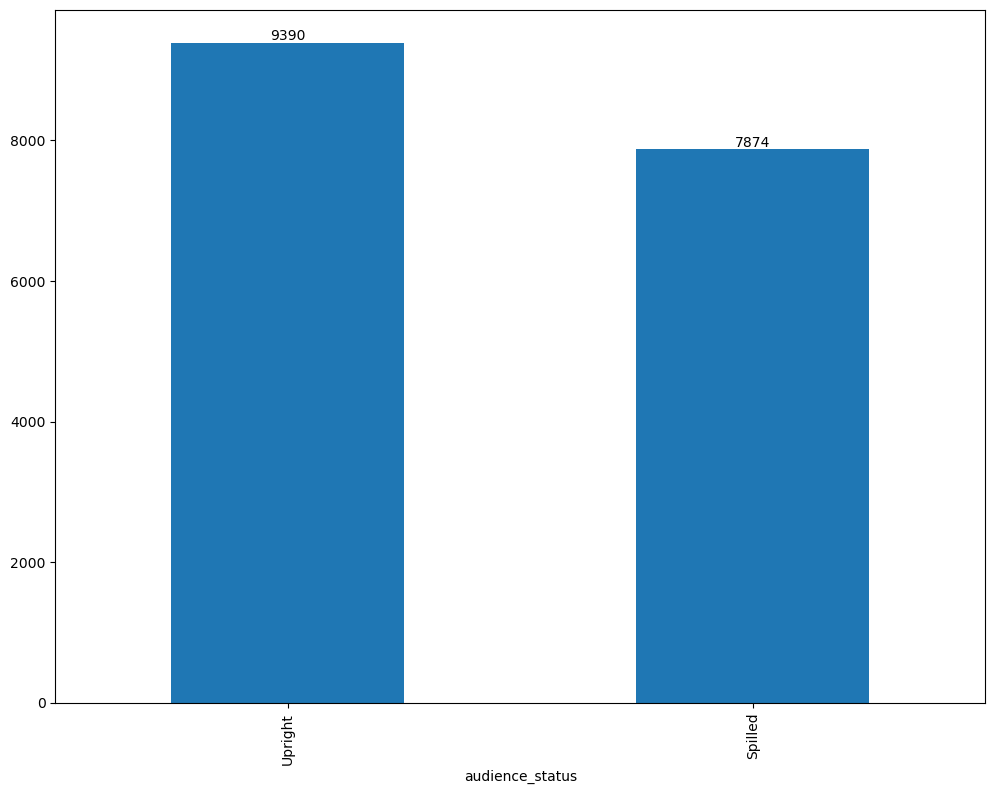

In [100]:
print(f'Audience status category: {df_movie.audience_status.unique()}')

# Visualize the distribution of each category
ax = df_movie.audience_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [18]:
#Encode audience status variable with ordinal encoding

audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled','Upright'],[0,1]).infer_objects(copy=False))
audience_status.head()

/var/folders/61/br8wr2d92qq0jbw44qm3yc3h0000gn/T/ipykernel_4487/2452658047.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled','Upright'],[0,1]).infer_objects(copy=False))


,audience_status
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


The last variable to encode is the target tomatometer_status. It contains three categories: Rotten, Fresh, and Certified-Fresh. To make it usable for modeling, I am applying ordinal encoding so that each category is mapped to a numeric value. This way the labels can be represented as 0, 1, 2 instead of text, allowing the model to process them as the dependent variable.

In [19]:
#Encode tomatometer status variable with ordinal encoding

tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten','Fresh','Certified-Fresh'],[0,1,2]))
tomatometer_status

/var/folders/61/br8wr2d92qq0jbw44qm3yc3h0000gn/T/ipykernel_4487/2056684334.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten','Fresh','Certified-Fresh'],[0,1,2]))


,tomatometer_status
0,0.0
1,2.0
2,1.0
3,2.0
4,1.0
...,...
17707,0.0
17708,2.0
17709,1.0
17710,1.0


At this stage, all required variables are encoded. The next step is combining them with the existing numerical features to form a single feature set. I am using pd.concat() to join these DataFrames side by side. Since some columns contain missing values, I am handling them by dropping any row that has a missing entry in at least one column. This keeps the dataset clean and ready for modeling.

In [20]:
df_feature = pd.concat([df_movie[['runtime','tomatometer_rating','tomatometer_count','audience_rating','audience_count',
                                  'tomatometer_top_critics_count','tomatometer_fresh_critics_count','tomatometer_rotten_critics_count']],
                                   content_rating,audience_status,tomatometer_status],axis=1).dropna()
df_feature.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,43,73,76,False,False,False,True,False,False,0.0,0.0
1,90.0,87.0,142.0,64.0,11574.0,44,123,19,False,False,False,False,False,True,1.0,2.0
2,122.0,67.0,24.0,53.0,14684.0,2,16,8,False,False,False,False,False,True,0.0,1.0
3,95.0,100.0,54.0,97.0,105386.0,6,54,0,False,False,True,False,False,False,1.0,2.0
4,127.0,89.0,27.0,74.0,68918.0,5,24,3,True,False,False,False,False,False,1.0,1.0


In [21]:
df_feature.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,audience_status,tomatometer_status
count,17017.000000,17017.000000,17017.000000,17017.000000,1.701700e+04,17017.000000,17017.000000,17017.000000,17017.000000,17017.000000
mean,102.296233,60.519539,57.097197,60.324499,1.471183e+05,14.765999,36.237292,20.871188,0.542928,0.752718
std,18.653649,28.436397,66.814580,20.480600,1.783955e+06,15.172256,51.362454,29.978900,0.498168,0.747250
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,44.000000,7.410000e+02,3.000000,6.000000,3.000000,0.000000,0.000000
50%,99.000000,66.000000,29.000000,62.000000,4.423000e+03,8.000000,17.000000,8.000000,1.000000,1.000000
75%,111.000000,86.000000,76.000000,77.000000,2.606700e+04,23.000000,44.000000,24.000000,1.000000,1.000000
max,266.000000,100.000000,535.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000,1.000000,2.000000


As you can see above, now we have all of the features that we can use as predictors for our machine learning algorithms, as well as the dependent variable tomatometer_status in one DataFrame. Notice that all of the variables now have 17017 entries after we drop any rows with a missing value in any of the columns. Next, let's see the distribution of our dependent variabletomatometer_status.

In [22]:
len(df_feature)

17017

[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

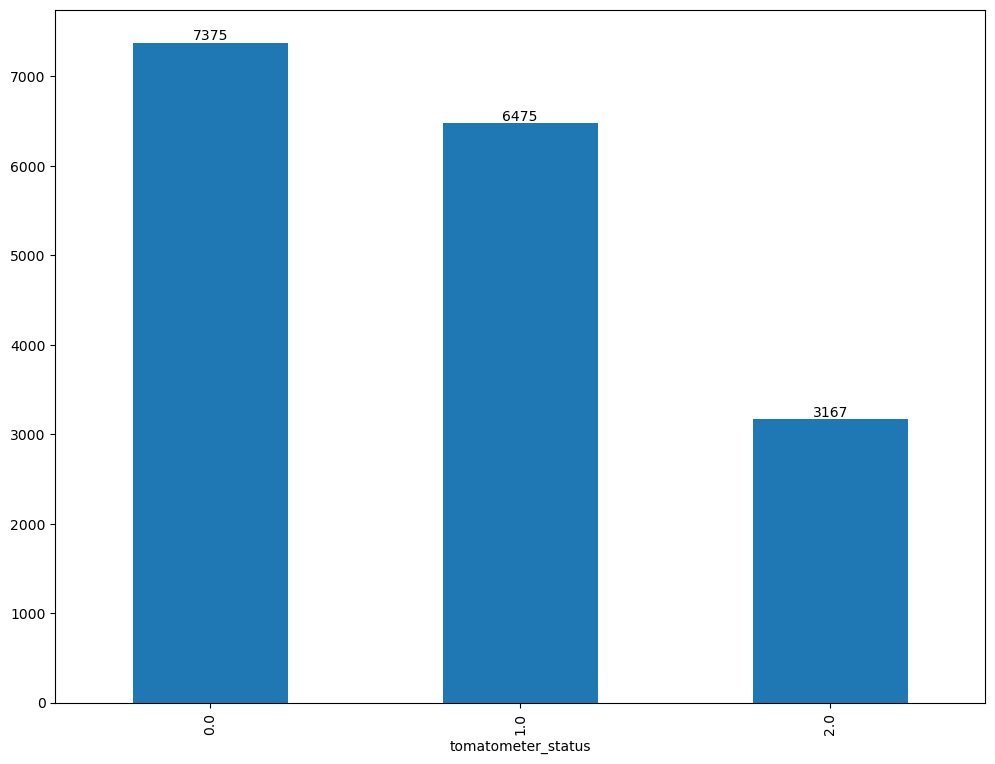

In [23]:
ax = df_feature.tomatometer_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

The final dataset shows 7375 movies labeled as Rotten, 6475 as Fresh, and 3167 as Certified-Fresh. This distribution reveals a class imbalance, since Rotten and Fresh are more frequent than Certified-Fresh.
I am proceeding with an 80–20 split into training and test sets to begin building and evaluating models.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status'],axis=1),
                                                   df_feature.tomatometer_status, 
                                                    test_size=0.2, 
                                                    random_state=42)
print(f'Size of training data is {len(X_train)} and the size of test data is {len(X_test)}')

Size of training data is 13613 and the size of test data is 3404


That completes the preprocessing stage. The dataset is now ready for modeling. I am starting with a Decision Tree Classifier to build the first predictive model for the Tomatometer status.

## Decision Tree Classifier

For the first run, I am limiting the Decision Tree to a maximum of 3 leaf nodes. This keeps the tree shallow and makes the decision process easier to interpret.

0.9462397179788484
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.97      0.88      0.93      1286
         2.0       0.80      0.95      0.87       630

    accuracy                           0.95      3404
   macro avg       0.92      0.94      0.93      3404
weighted avg       0.95      0.95      0.95      3404



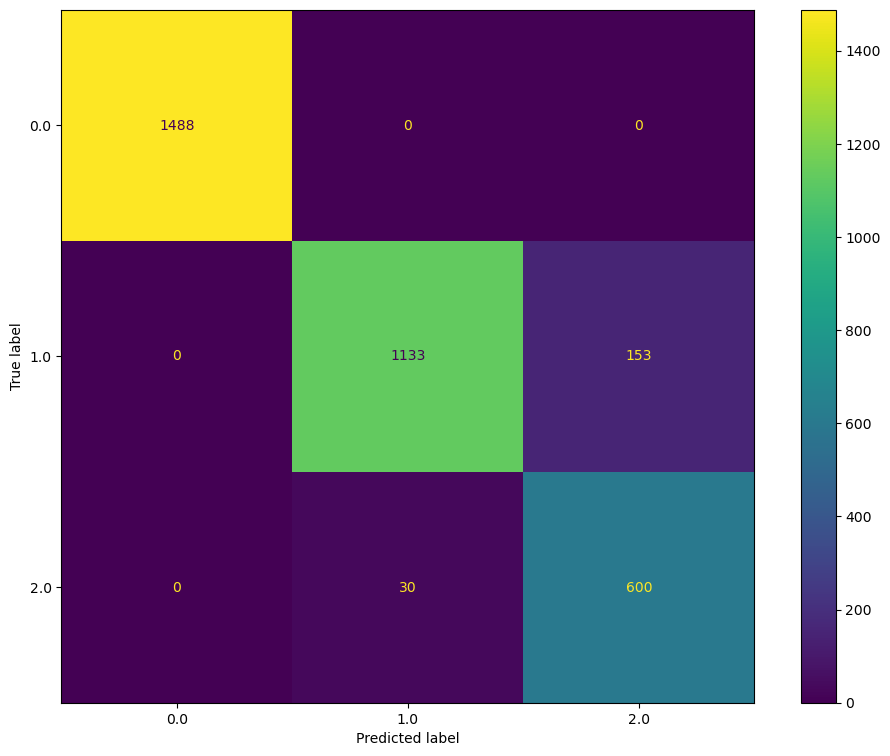

In [44]:
# Instantiate Decision Tree Classifier with max leaf nodes = 3
tree_3_leaf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=2)

# Train the classifier on the training data
tree_3_leaf.fit(X_train, y_train)

# Predict the test data with trained tree classifier
y_predict = tree_3_leaf.predict(X_test)

# Print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot confusion matrix on test data
fig, ax = plt.subplots(figsize=(12, 9))
ConfusionMatrixDisplay.from_estimator(
    tree_3_leaf, X_test, y_test, cmap = 'viridis', ax=ax
)
plt.show()

The Decision Tree Classifier shows reasonable accuracy and the confusion matrix reflects its performance, even with the constraint of just three leaf nodes. Keeping the tree this shallow makes the decision process easy to follow and explain. To visualize how the model is splitting the data, I am going to use the plot_tree function from sklearn.tree.

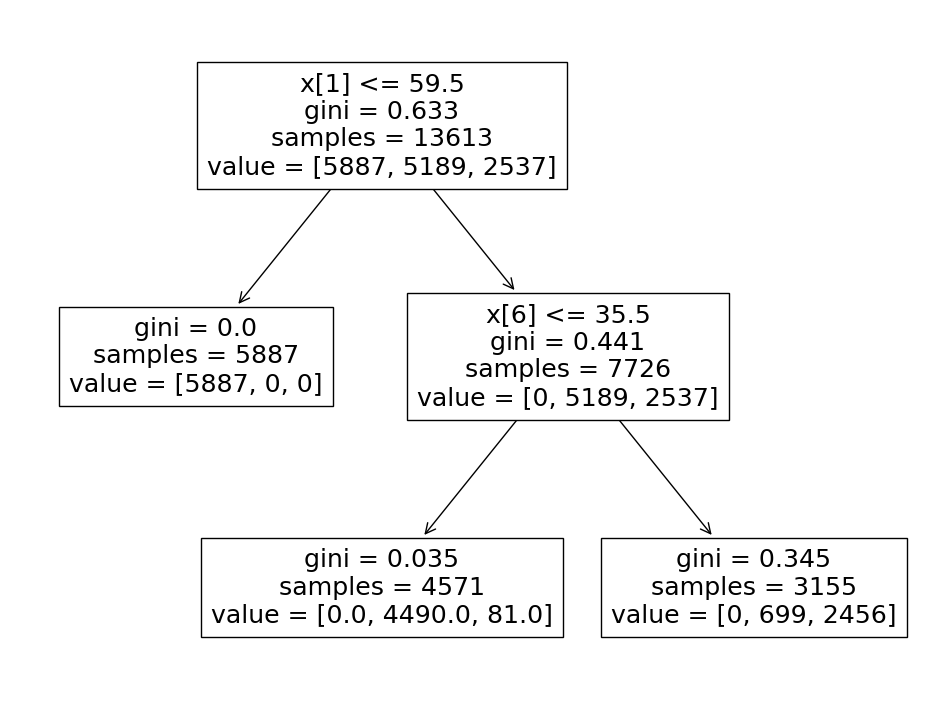

In [32]:
fig, ax = plt.subplots(figsize=(12,9))
plot_tree(tree_3_leaf, ax=ax)
plt.show()

The tree visualization illustrates how the classifier makes its decisions. Looking back at df_feature, the feature at index 1 is tomatometer_rating, which the tree uses at the root split. If a movie’s rating is 59.5 or below, the classifier assigns it to class 0 (Rotten). Otherwise, the data point is passed to the next branch.

At the second split, the tree uses the feature at index 6, tomatometer_fresh_critics_count. If the count is 35.5 or below, the movie is classified as class 1 (Fresh). If the count is higher, the movie is classified as class 2 (Certified-Fresh).

This step-by-step branching shows how a shallow tree makes predictions based on just a couple of features.

If a movie has a tomatometer_rating above 59.5, then the model needs to take a look at several features to find out whether a movie is 'Fresh' or 'Certified-Fresh'. If you take a look at the Rotten Tomatoes homepage, there are several considerations that need to be taken into account for a movie to be considered as 'Certified-Fresh' instead of just 'Fresh', such as:

A consistent Tomatometer score of at least 75%
At least 5 reviews from Top Critics
Films in wide release must have a minimum of 80 reviews
As you can see, several variables need to be taken into account to distinctively classify whether a movie is 'Fresh' or 'Certified-Fresh'. Since we constrained our Decision Tree model, then it uses the number of top critics' review as the sole variable to classify whether a movie is 'Fresh' or 'Certified-Fresh'

Now that we know how a decision tree classifies each data point, let's try to optimize the accuracy score by removing the maximum leaf nodes constraint that we have set in the beginning.

0.9900117508813161
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.97      0.97      0.97       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



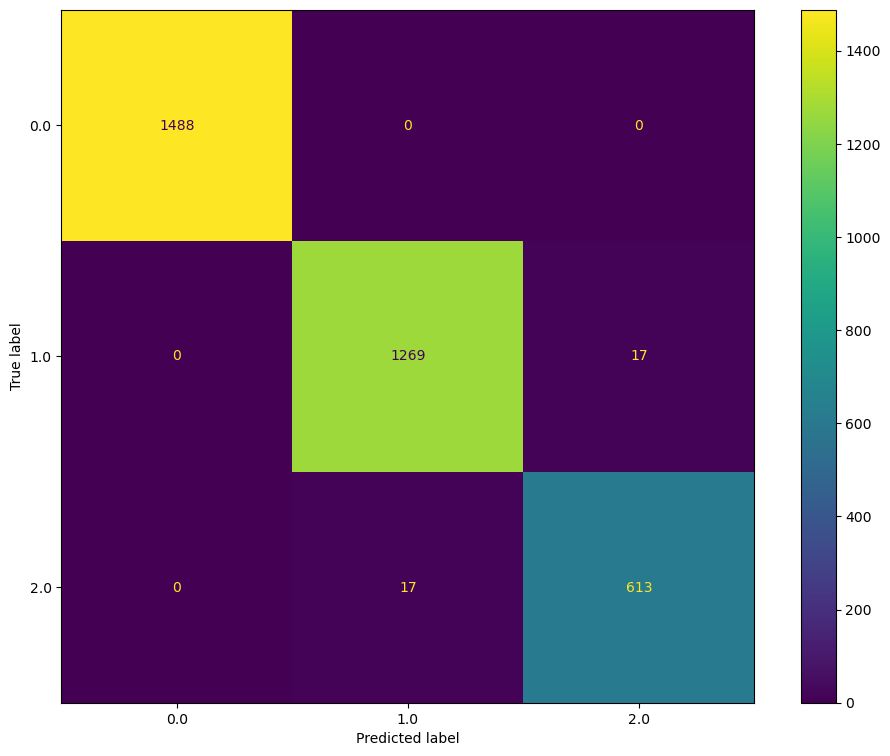

In [43]:
# Instantiate Decision Tree Classifier with default hyperparameter settings
tree = DecisionTreeClassifier(random_state=2)

# Train the classifier on the training data
tree.fit(X_train, y_train)

# Predict the test data with trained tree classifier
y_predict = tree.predict(X_test)

# Print accuracy and classification report on test data
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot confusion matrix on test data
fig, ax = plt.subplots(figsize = (12,9))
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap='viridis', ax=ax)

The classifier’s accuracy, precision, and recall have improved, reaching 99% compared to the earlier 94%. Allowing the model to determine the optimal number of leaf nodes clearly boosts performance. While this looks strong, there is still room to explore whether further optimization can push accuracy even higher.

## Random Forest Classifier

Implementing Random Forest with Scikit-learn is straightforward. Similar to Decision Trees, the algorithm offers hyperparameters to tune, such as the number of trees, the maximum depth, and the number of leaf nodes. For the first run, the model is built using the default settings provided by Scikit-learn.

0.9911868390129259
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.97      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



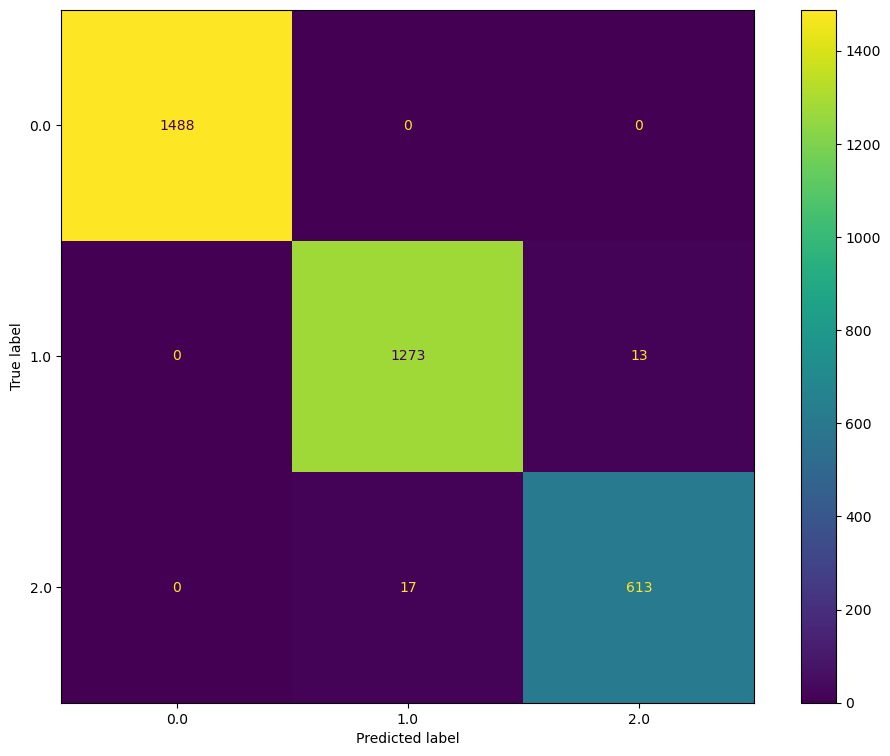

In [42]:
# Instantiate Random Forest Classifier
rf = RandomForestClassifier(random_state=2)

# Train Random Forest Classifier on training data
rf.fit(X_train, y_train)

# Predict test data with trained model
y_predict = rf.predict(X_test)

# Print accuracy score and classification report
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12,9))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='viridis', ax=ax)

The accuracy and confusion matrix show that the Random Forest performs slightly better than the single Decision Tree, highlighting the strength of ensemble methods over individual classifiers. An added advantage of tree-based models is the ability to measure feature importance, which reveals which variables contribute most to predictions and which have less influence.

In Scikit-learn, the relative importance of each feature can be retrieved using the feature_importances_ attribute. This provides a score for every feature, showing how much it contributes to the model’s predictions.

runtime = 0.006116739944983344
tomatometer_rating = 0.47608504652994854
tomatometer_count = 0.09880146707250363
audience_rating = 0.05404262467299177
audience_count = 0.016251677241949883
tomatometer_top_critics_count = 0.03608963155901569
tomatometer_fresh_critics_count = 0.14150645695305125
tomatometer_rotten_critics_count = 0.13081343489058472
G = 0.00029848189185319515
NC17 = 1.709061066955017e-05
NR = 0.008711786826541734
PG = 0.0005668613959766321
PG-13 = 0.002531466583040525
R = 0.002232419076842232
audience_status = 0.02593481475004731


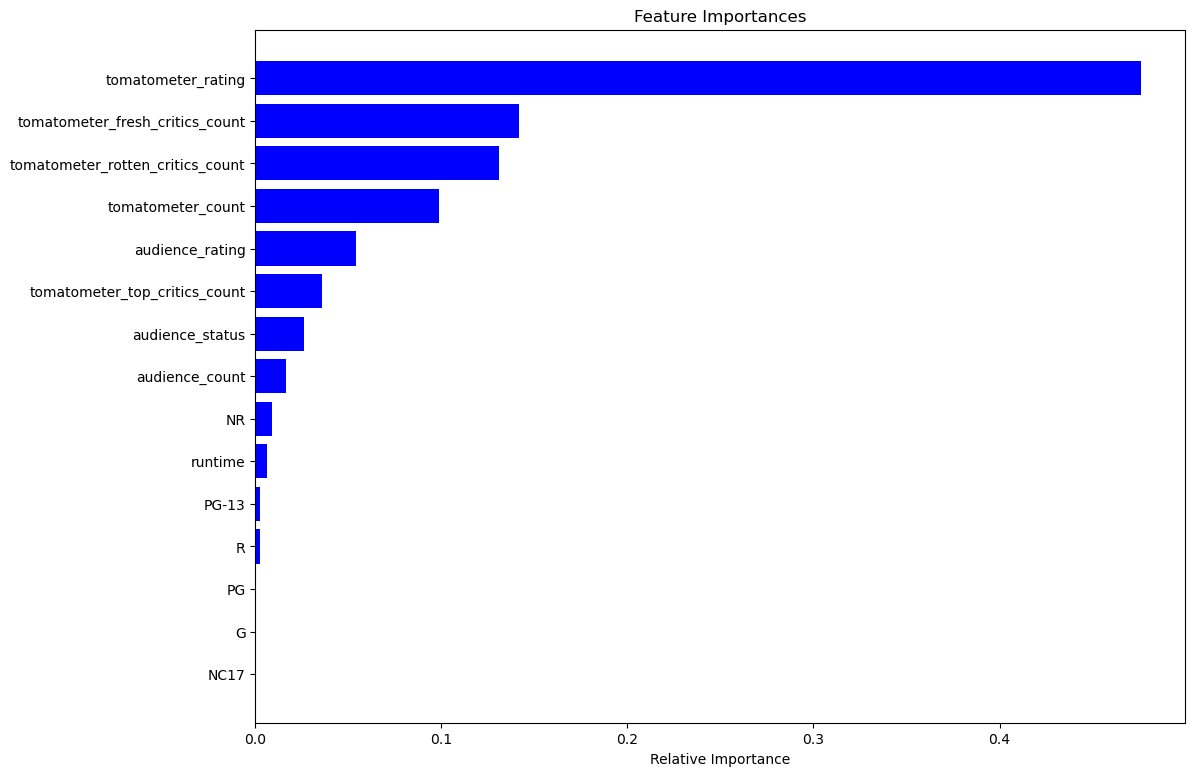

In [45]:
# Get the feature importance
feature_importance = rf.feature_importances_

# Print feature importance
for i, feature in enumerate(X_train.columns):
    print(f'{feature} = {feature_importance[i]}')

# Visualize feature from the most important to the least important
indices = np.argsort(feature_importance)

plt.figure(figsize=(12,9))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The results show that features like content_rating categories (NR, PG-13, R, etc.) and runtime have little influence on the model when predicting unseen data. The next step is exploring whether removing or adjusting these features can improve the performance of the Random Forest classifier.

## Random Forest Classifier with Feature Selection

Since some features were shown to have low importance in the Random Forest model, the next step is removing them from the dataset. This includes NR, runtime, PG-13, R, PG, G, and NC17, which are unlikely to contribute meaningfully to predictions.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status','NR','runtime','PG-13','R','PG','G','NC17'], axis=1),
                                                    df_feature.tomatometer_status, test_size=0.2, random_state=42)
print(f'Size of training data is {len(X_train)} and the size of test data is {len(X_test)}')

Size of training data is 13613 and the size of test data is 3404


With a refined set of features, the Random Forest classifier can be retrained. This demonstrates the idea of feature selection, where adding or removing variables helps test whether performance improves. The goal here is to see if the model achieves better results after dropping less useful features.

0.9917743830787309
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.97      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



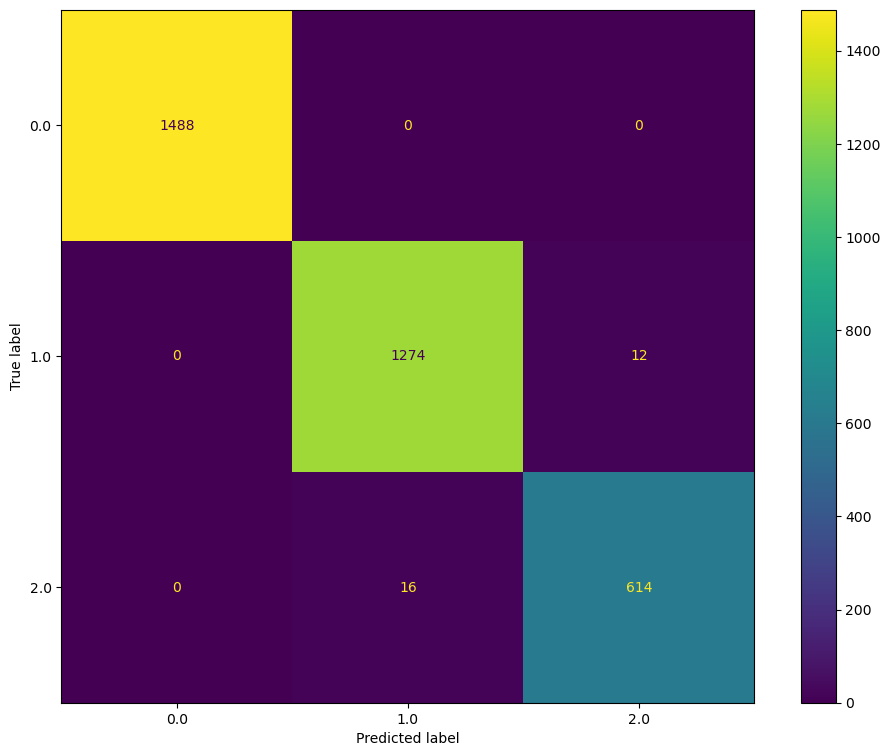

In [52]:
# Initialize Random Forest Class
rf = RandomForestClassifier(random_state=2)

# Train Random Forest on the training data after feature selection
rf.fit(X_train, y_train)

# Predict the trained model on the test data after feature selection
y_predict = rf.predict(X_test)

# Print the Accuracy Score and the Classification Report
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot the Confusion Matrix
fig, ax = plt.subplots(figsize = (12,9))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='viridis', ax=ax)

After feature selection, the model’s performance improved, reaching 99.1% accuracy. Both False Positive and False Negative rates decreased slightly compared to the earlier version. This highlights that more features do not always lead to better models, as irrelevant variables can introduce noise and reduce prediction reliability.

## Weighted Random Forest Classifier with Feature Selection

As noted in the preprocessing stage, the target variable is not evenly distributed. The three classes are Rotten (0), Fresh (1), and Certified-Fresh (2), and their counts show an imbalance that may affect how the model learns and predicts.

[Text(0, 0, '7375'), Text(0, 0, '6475'), Text(0, 0, '3167')]

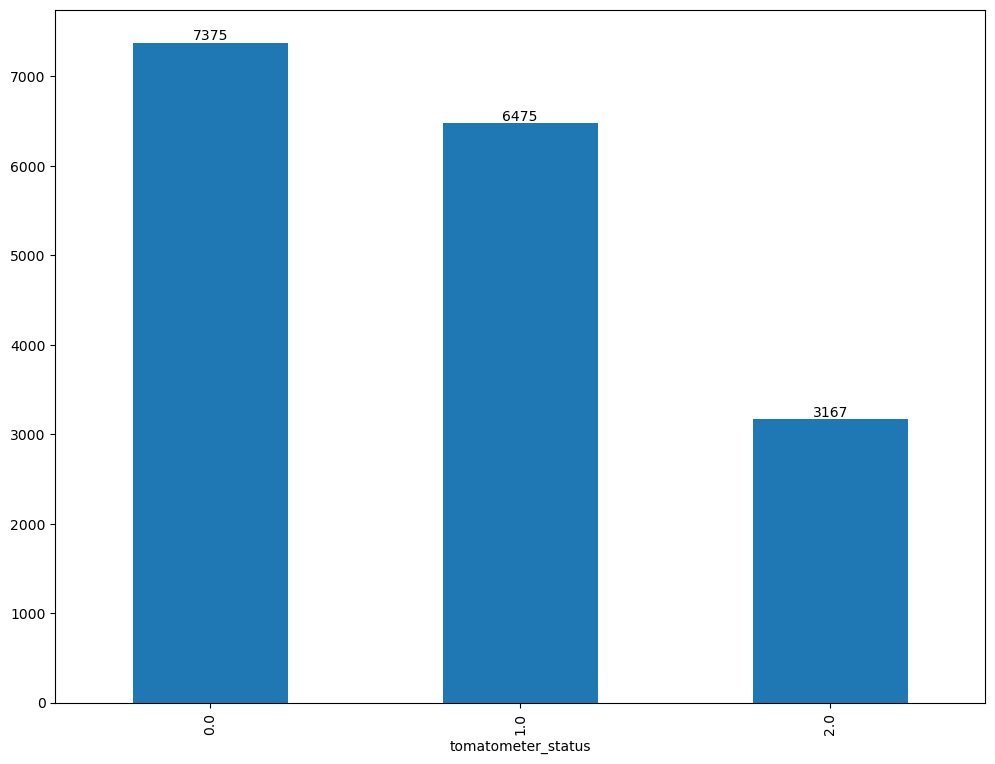

In [54]:
ax = df_feature.tomatometer_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

Class imbalance is clear here: Certified-Fresh has far fewer samples than Rotten. To address this, there are two common routes: oversampling the minority class (for example, SMOTE) or giving the model class weights during training. In this notebook, I am using class weights so the minority class gets a higher penalty when misclassified. I am going to compute weights with sklearn.utils.class_weight.compute_class_weight and pass the resulting dictionary to the classifier, so the model learns to pay more attention to underrepresented labels.

In [55]:
class_weight = compute_class_weight(
    class_weight = 'balanced', classes = np.unique(df_feature.tomatometer_status),
    y = df_feature.tomatometer_status.values)
class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 0.7691299435028248, 1: 0.8760360360360361, 2: 1.7910746237238186}

The computed weights show that the majority class Rotten (0) is assigned the smallest weight, while the minority class Certified-Fresh (2) receives the largest weight. I now initialize the Random Forest classifier with this class weight information, retrain it on the training data, generate predictions on the test set, and then evaluate the model using the accuracy score and confusion matrix visualization.

0.9929494712103408
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1488
         1.0       0.99      0.99      0.99      1286
         2.0       0.98      0.98      0.98       630

    accuracy                           0.99      3404
   macro avg       0.99      0.99      0.99      3404
weighted avg       0.99      0.99      0.99      3404



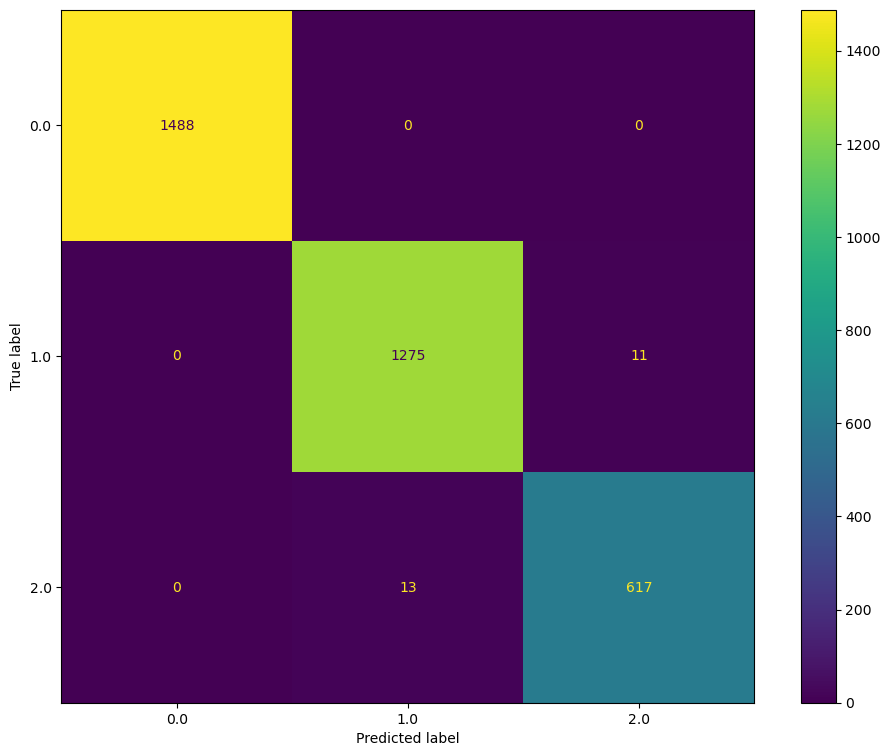

In [59]:
# Initialize Random Forest model with weight information
rf_weighted = RandomForestClassifier(random_state=2, class_weight=class_weight_dict)

# Train the model on the training data
rf_weighted.fit(X_train, y_train)

# Predict the test data with the trained model
y_predict = rf_weighted.predict(X_test)

# Print the Accuracy Score and Classification Report
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12,9))
ConfusionMatrixDisplay.from_estimator(rf_weighted, X_test, y_test, cmap='viridis', ax=ax)

After applying class weights, the model’s performance improved, with accuracy rising to 99.2% and an increase in correct predictions for the Fresh class. Using class weights is an effective way to handle imbalance since it forces the model to give greater importance to underrepresented labels during training.

## Second Approach: Predicting Movie Status Using Review Sentiment

I’m switching to a sentiment-based approach where the model predicts movie status from the tone of critic reviews. Negative sentiment maps to Rotten, positive sentiment maps to Fresh. Since this uses text instead of tabular features, I will load a separate reviews dataset, convert the text into numeric vectors, and then train a Random Forest for classification. 

First step: inspect the review data.

In [60]:
df_critics = pd.read_csv('/Users/madhulika/Downloads/rotten_tomatoes_critic_reviews_50k.csv')
df_critics.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


From the data above, we have the review_content variable, which is the input data that we will supply to our Decision Tree model, and review_type variable, which is the variable that our model will predict.

The reviews dataset does not directly include the movie title or the Tomatometer status. What it does contain is the rotten_tomatoes_link, which also appears in the movies dataset. Since the movies dataset provides both movie_title and tomatometer_status, I can merge the two DataFrames on the rotten_tomatoes_link column to bring in the missing information for each review.

In [62]:
df_merged = df_critics.merge(df_movie, how='inner', on=['rotten_tomatoes_link'])
df_merged = df_merged[['rotten_tomatoes_link','movie_title','review_content','review_type','tomatometer_status']]

In [63]:
df_merged.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Uma Thurman as Medusa, the gorgon with a coiff...",Fresh,Rotten
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,With a top-notch cast and dazzling special eff...,Fresh,Rotten
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,Whether audiences will get behind The Lightnin...,Fresh,Rotten
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,What's really lacking in The Lightning Thief i...,Rotten,Rotten


For this approach, the only input feature used is review_content, with review_type serving as the label. Since empty reviews cannot be used, missing values in review_content are removed. After filtering, I keep just the review_content and review_type columns and then plot the distribution of the labels to see how many reviews are classified as Fresh versus Rotten.

In [64]:
df_merged = df_merged.dropna(subset=['review_content'])

[Text(0, 0, '25276'), Text(0, 0, '15919')]

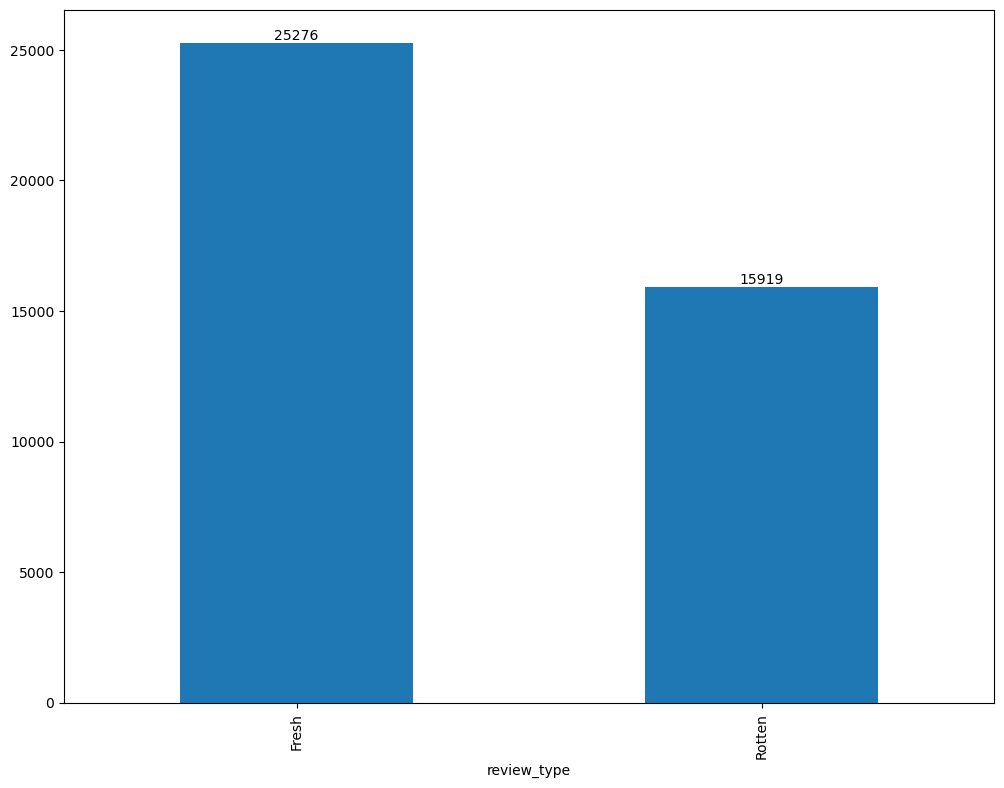

In [65]:
# Plot distribution of the review
ax = df_merged.review_type.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

The label distribution is imbalanced, which suggests that adding class weights during training will be useful. The dataset itself has over 100k reviews, but to keep training efficient in this example, I will work with a subset of 5000 entries.

The labels are converted from text values (Rotten, Fresh) to integers using ordinal encoding. This assigns 0 to Rotten and 1 to Fresh, making the target variable numeric and ready for training.

In [66]:
# Picking only 5000 entries from the original dataset
df_sub = df_merged[0:5000]

# Encode the label
review_type = pd.DataFrame(df_sub.review_type.replace(['Rotten','Fresh'],[0,1]))

# Build final DataFrame
df_feature_critics = pd.concat([df_sub[['review_content']], review_type], axis=1).dropna()
df_feature_critics.head()

/var/folders/61/br8wr2d92qq0jbw44qm3yc3h0000gn/T/ipykernel_4487/1367458876.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  review_type = pd.DataFrame(df_sub.review_type.replace(['Rotten','Fresh'],[0,1]))


,review_content,review_type
0,A fantasy adventure that fuses Greek mythology...,1
1,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,With a top-notch cast and dazzling special eff...,1
3,Whether audiences will get behind The Lightnin...,1
4,What's really lacking in The Lightning Thief i...,0


The dataset is then divided into training and test sets, with the training portion used to fit the model and the test portion reserved for evaluating its performance.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df_feature_critics['review_content'], df_feature_critics['review_type'], test_size=0.2, random_state=42)

## Default Random Forest

Reviews in the dataset are text, so they need to be transformed into a numerical form that a machine learning model can work with. This process is handled through tokenization, where words are broken down and represented as vectors. The approach used here is converting reviews into a matrix of token counts. For example, from the sentences “This movie is a good movie” and “The movie is bad”, a dictionary of unique words is built: [this, movie, is, a, good, the, bad]. Each review is then represented by the frequency of these words, resulting in a numeric vector such as [1, 2, 1, 1, 1, 0, 0]. These vectors become the input for training the Random Forest classifier. In practice, this process is implemented in scikit-learn with the CountVectorizer class.

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       448
           1       0.72      0.72      0.72       552

    accuracy                           0.69      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.69      0.69      0.69      1000



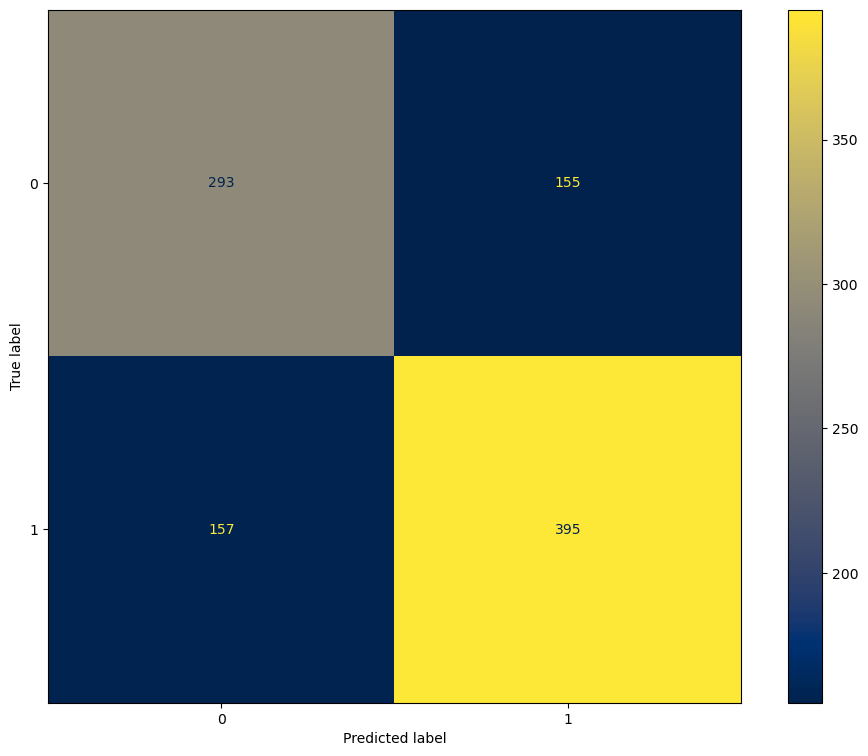

In [75]:
# Instantiate vectorizer class
vectorizer = CountVectorizer(min_df=1)

# Transform our text data into vector
X_train_vec = vectorizer.fit_transform(X_train).toarray()

# Initialize random forest and train it
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train_vec, y_train)

# Predict and output classification report
y_predicted = rf.predict(vectorizer.transform(X_test).toarray())

print(classification_report(y_test, y_predicted))

fig, ax = plt.subplots(figsize=(12,9))
ConfusionMatrixDisplay.from_estimator(rf, vectorizer.transform(X_test).toarray(), y_test, cmap='cividis', ax=ax)
plt.show()

## Weighted Random Forest

The model’s performance is relatively weak, which is expected given it was trained on just 5000 samples instead of the full dataset of 100,000 reviews. Since the labels are imbalanced, the next step is to introduce class weights during training to see if this improves the results.

In [76]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(df_feature_critics.review_type), 
                                   y=df_feature_critics.review_type.values)
class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 1.058425063505504, 1: 0.9476876421531463}

The next step is fitting the Random Forest classifier on the vectorized review data while supplying class weight information. This adjustment helps the model handle the imbalance between Fresh and Rotten reviews and should improve prediction performance.

              precision    recall  f1-score   support

           0       0.64      0.71      0.67       448
           1       0.74      0.67      0.70       552

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



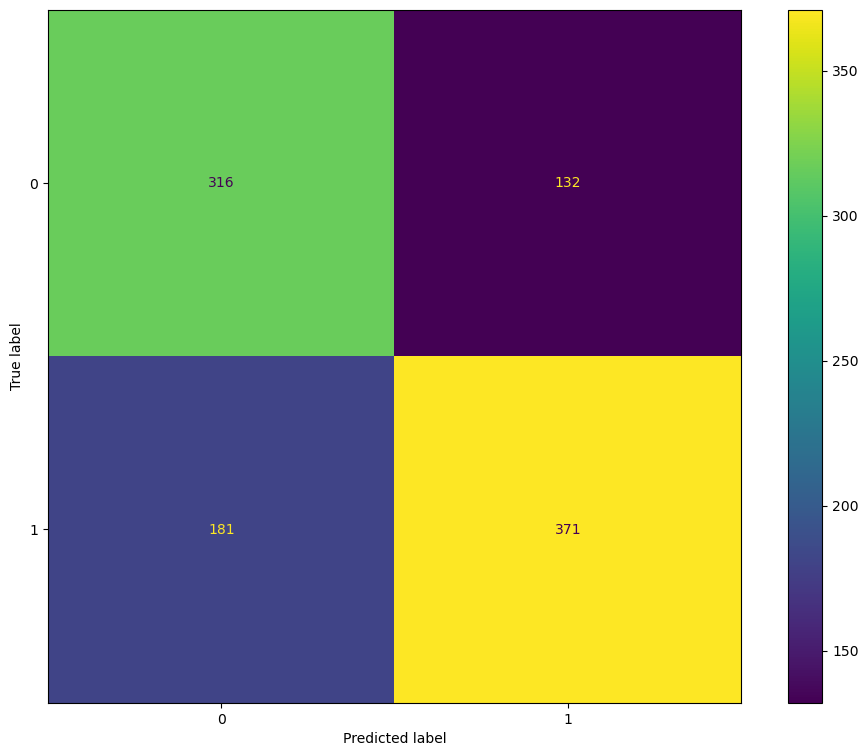

In [80]:
# Instantiate vectorizer class
vectorizer = CountVectorizer(min_df=1)

# Transform our text data into vector
X_train_vec = vectorizer.fit_transform(X_train).toarray()

# Initialize random forest and train it 
rf_weighted = RandomForestClassifier(random_state=2, class_weight=class_weight_dict)
rf_weighted.fit(X_train_vec, y_train)

# Predict and output classification report 
y_predicted = rf_weighted.predict(vectorizer.transform(X_test).toarray())

print(classification_report(y_test, y_predicted))

fig, ax = plt.subplots(figsize=(12,9))
ConfusionMatrixDisplay.from_estimator(rf_weighted, vectorizer.transform(X_test).toarray(), y_test, cmap='viridis', ax=ax)


Overall accuracy improves slightly after adding class weights. Because class 0 (Rotten) carries a higher weight than class 1 (Fresh), the model now predicts Rotten reviews more accurately but performs worse on Fresh reviews. The weighting shifts attention toward the minority or emphasized class, which changes the error balance across labels.

## Movie Status Prediction

With the Random Forest model trained to classify individual reviews as Fresh or Rotten, the next step is extending this to predict the overall status of a movie. The process is straightforward:

1. Collect all reviews for a given movie.
2. Use the model to predict each review’s status.
3. Apply Rotten Tomatoes’ rule: if at least 60% of reviews are Fresh, the movie is classified as Fresh; otherwise, it is Rotten.

This means summing the number of reviews predicted as Fresh, dividing by the total reviews, and checking whether the ratio exceeds 60%.

The next step is defining a function that implements the rule-based aggregation. The function will take all reviews for a movie, predict each one using the trained Random Forest model, calculate the percentage of Fresh reviews, and then assign the movie a final status of Fresh or Rotten based on the 60% threshold.

In [82]:
def predict_movie_status(prediction):
    """Assign label (Fresh/Rotten) based on prediction"""
    positive_percentage = (prediction==1).sum()/len(prediction)*100
    prediction = 'Fresh' if positive_percentage >=60 else 'Rotten'
    print(f'Positive review: {positive_percentage:.2f}%')
    print(f'Movie status: {prediction}')

In this example, the model is used to predict the status of three movies: Body of Lies, Angel Heart, and The Duchess. The process begins with Body of Lies, where all available reviews are collected, classified with the trained Random Forest model, and then aggregated into a final movie status.

### Body of Lies Prediction

Using the trained Random Forest sentiment model, all reviews for Body of Lies are collected, transformed with the vectorizer, and individually classified as Fresh or Rotten. The percentage of reviews predicted as Fresh is then computed, and based on the Rotten Tomatoes rule (≥60% Fresh = Fresh, <60% Fresh = Rotten), the overall movie status is determined.

In [85]:
# Gathering all the reviews for the movie Body of Lies
df_bol = df_merged.loc[df_merged['movie_title']=='Body of Lies']

In [86]:
df_bol.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
7382,m/10009225-body_of_lies,Body of Lies,DiCaprio (not Crowe) is in top form in Scott's...,Fresh,Rotten
7383,m/10009225-body_of_lies,Body of Lies,Neither the location-based verisimilitude of R...,Rotten,Rotten
7384,m/10009225-body_of_lies,Body of Lies,"DiCaprio gives the role plenty of brio, while ...",Fresh,Rotten
7385,m/10009225-body_of_lies,Body of Lies,"Convincing and gripping, Body of Lies is at th...",Fresh,Rotten
7386,m/10009225-body_of_lies,Body of Lies,Lies and consequences form the heart of this b...,Fresh,Rotten


Now that the reviews are collected, the next step is using the trained Random Forest model to predict the sentiment of each review. The predictions are then passed into the function created earlier, which calculates the percentage of Fresh reviews and applies the Rotten Tomatoes rule (≥60% Fresh = Fresh, otherwise Rotten) to assign the movie its final status.

In [88]:
y_predicted_bol = rf_weighted.predict(vectorizer.transform(df_bol['review_content']).toarray())
predict_movie_status(y_predicted_bol)

Positive review: 51.96%
Movie status: Rotten


The model predicts Body of Lies as Rotten, since only about 51% of its reviews were classified as Fresh, which is below the 60% threshold. To check the reliability of this result, the predicted status can be compared against the actual tomatometer_status from the movies dataset.

In [89]:
df_merged['tomatometer_status'].loc[df_merged['movie_title']== 'Body of Lies'].unique()

array(['Rotten'], dtype=object)

The actual Tomatometer status for Body of Lies is Rotten, which aligns with the model’s prediction and confirms it classified the movie correctly.

### 'Angel Heart' Prediction

Following the same procedure as before, I will collect all reviews for Angel Heart, use the model to predict each one, and then calculate the percentage of reviews classified as positive.

In [90]:
# Gather all the reviews of Anna Karenina movie
df_ah = df_merged.loc[df_merged['movie_title']=='Angel Heart']
df_ah.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
9240,m/1000959-angel_heart,Angel Heart,"Angel Heart is a thriller and a horror movie, ...",Fresh,Fresh
9245,m/1000959-angel_heart,Angel Heart,Alan Parker's pulp sensibilities are beautiful...,Fresh,Fresh
9246,m/1000959-angel_heart,Angel Heart,One of the few truly great modern horror films,Fresh,Fresh
9248,m/1000959-angel_heart,Angel Heart,"Erotic, twisty and incredibly disturbed. Splen...",Fresh,Fresh
9249,m/1000959-angel_heart,Angel Heart,Este excepcional noir conta com maravilhosa fo...,Fresh,Fresh


In [91]:
y_predicted_ah = rf_weighted.predict(vectorizer.transform(df_ah['review_content']).toarray())
predict_movie_status(y_predicted_ah)

Positive review: 66.67%
Movie status: Fresh


With 66.7% of its reviews predicted as positive, Angel Heart is classified as Fresh by the model. The next step is checking its actual Tomatometer status for comparison.

In [92]:
df_merged['tomatometer_status'].loc[df_merged['movie_title']== 'Angel Heart'].unique()

array(['Fresh'], dtype=object)

The model correctly identified the status of Angel Heart. Moving on, the next movie to evaluate is The Duchess.

### 'THE DUCHESS' PREDICTION

In [95]:
# Gather all the reviews of the Duchess movie
df_duchess = df_merged.loc[df_merged['movie_title']== 'The Duchess']
df_duchess.head()

,rotten_tomatoes_link,movie_title,review_content,review_type,tomatometer_status
8558,m/10009493-duchess,The Duchess,For all its luscious period trappings and Keir...,Rotten,Fresh
8559,m/10009493-duchess,The Duchess,Solid but distant melodrama about the flamboya...,Fresh,Fresh
8560,m/10009493-duchess,The Duchess,"It could have been an intriguing, poignant sag...",Rotten,Fresh
8561,m/10009493-duchess,The Duchess,Has riveting parallels with much more recent B...,Fresh,Fresh
8562,m/10009493-duchess,The Duchess,Ralph Fiennes steals it as the dour duke in a ...,Fresh,Fresh


In [96]:
y_predicted_duchess = rf_weighted.predict(vectorizer.transform(df_duchess['review_content']).toarray())
predict_movie_status(y_predicted_duchess)

Positive review: 60.74%
Movie status: Fresh


The model output shows that 60.74% of reviews were predicted as positive, placing The Duchess just above the 60% threshold and resulting in a Fresh classification. The next step is to compare this outcome with the movie’s actual Tomatometer status.

In [97]:
df_merged['tomatometer_status'].loc[df_merged['movie_title']== 'The Duchess'].unique()

array(['Fresh'], dtype=object)